**Comparing different Dimensions**

Experimenting with resolution: 28x28


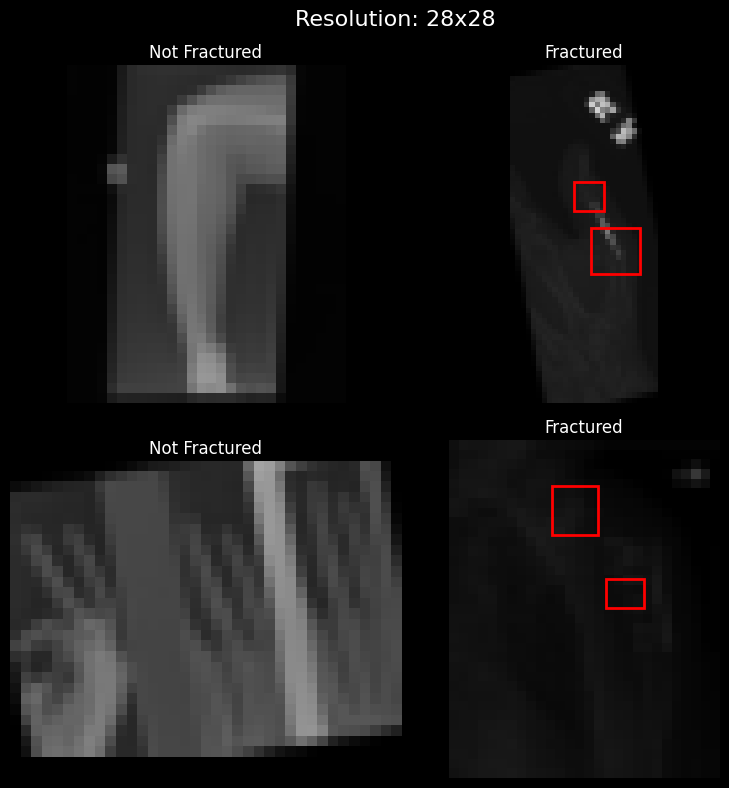

Experimenting with resolution: 56x56


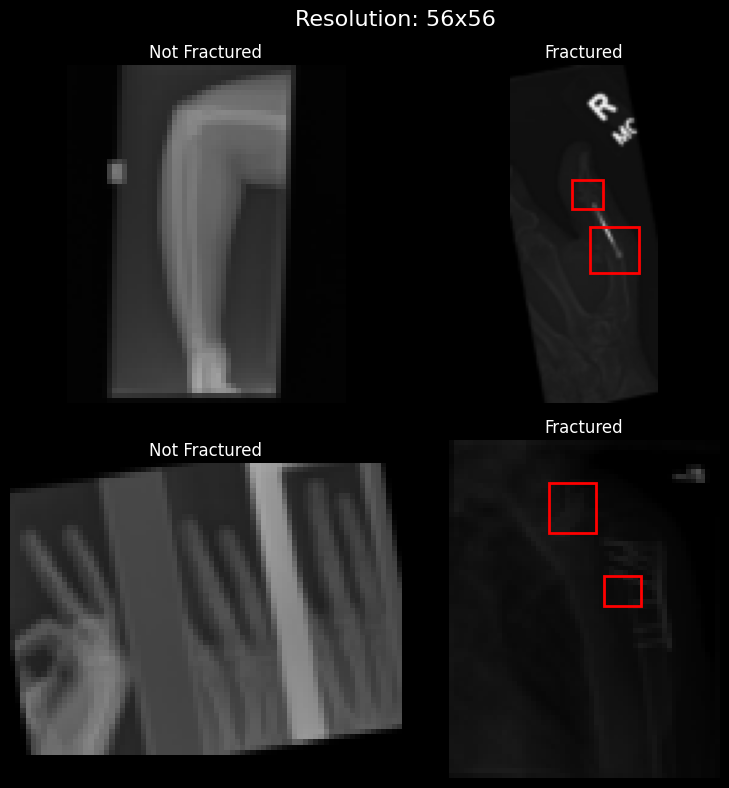

Experimenting with resolution: 128x128


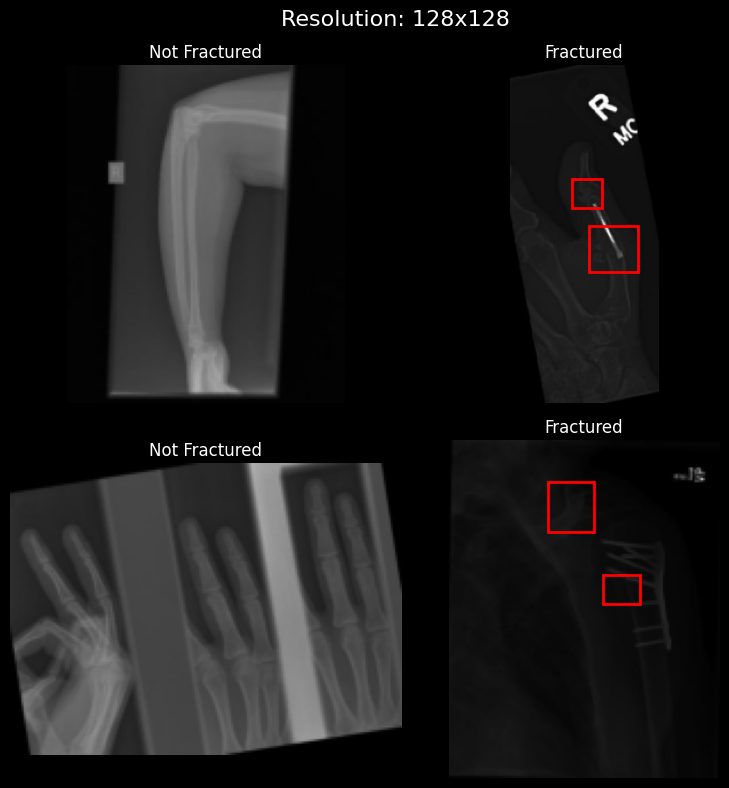

Experimenting with resolution: 256x256


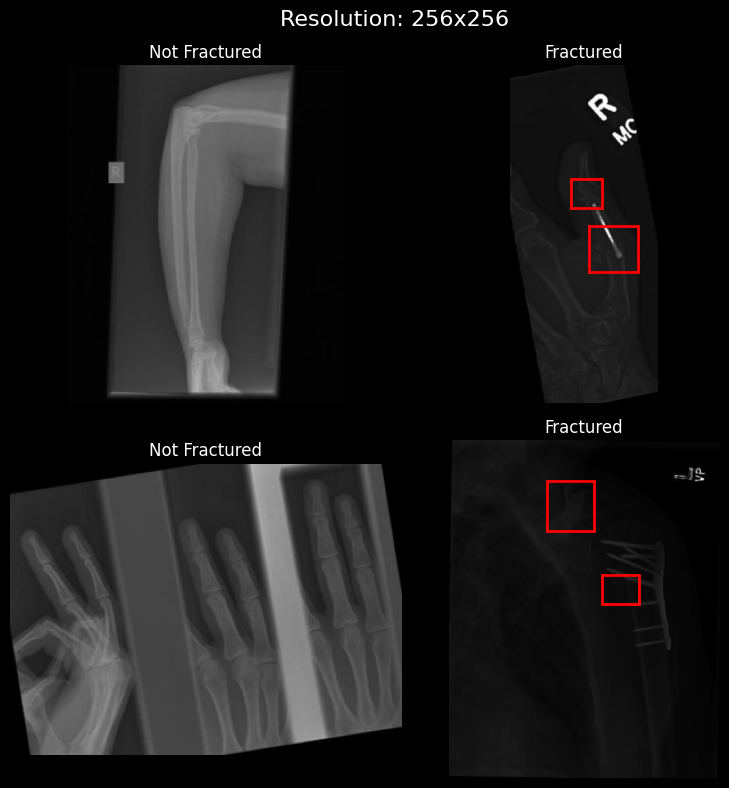

Experimenting with resolution: 512x512


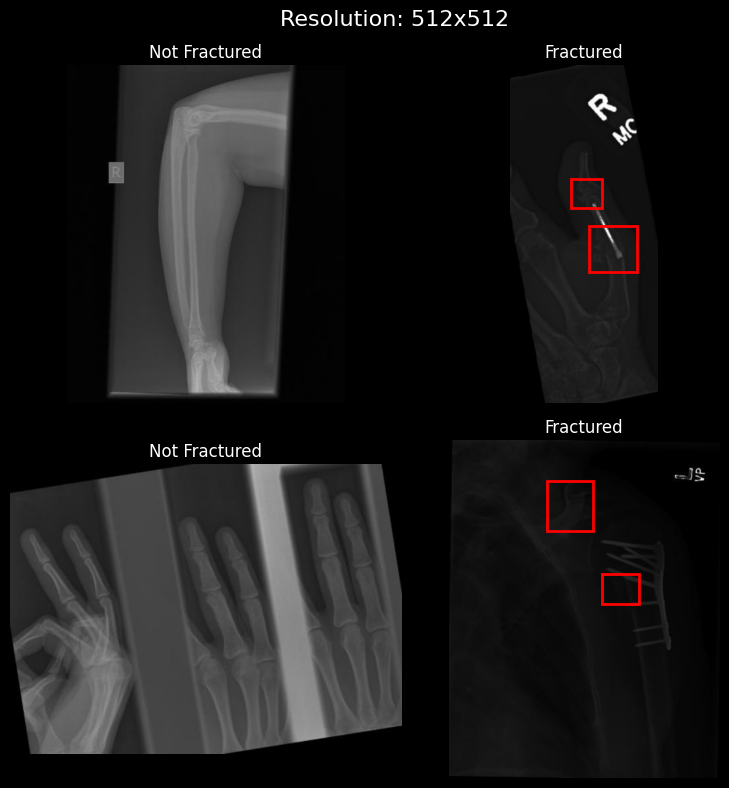

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

# Define directories
Test = '/home/elt/rw372/notebook/COMP8260 - A.I Systems/Project/Dataset/test/'
Train = '/home/elt/rw372/notebook/COMP8260 - A.I Systems/Project/Dataset/train/'
Valid = '/home/elt/rw372/notebook/COMP8260 - A.I Systems/Project/Dataset/valid/'

# Define transforms for experimenting with different image resolutions
def get_transform(load_shape):
    return transforms.Compose([
        transforms.Resize(load_shape),
        transforms.ToTensor(),
    ])

# Adjust the ImageDataset class to accept the load_shape parameter
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train', load_shape=128):
        self.transform = transform
        self.load_shape = load_shape
        self.files = sorted(glob.glob(os.path.join(root, mode) + '/images/*.jpg'))
        self.labels = {}
        self.boxes = {}
        assert len(self.files) > 0, "Make sure you downloaded the images!"

    def get_image(self, index):
        item = self.transform(Image.open(self.files[index % len(self.files)]))
        if item.shape[0] != 3: 
            item = item.repeat(3, 1, 1)
        return item

    def get_labels(self, index):
        if index in self.labels:
            return self.labels[index]
        labels = []
        boxes = []
        text_file = self.files[index % len(self.files)].replace(".jpg", ".txt").replace("images", "labels")
        with open(text_file, mode="r") as f:
            lines = f.readlines()
            for line in lines:
                values = [float(value) for value in line.split()]
                label = int(values[0])
                coords = values[1:]
                coords = torch.reshape(torch.FloatTensor(coords), (int(len(coords)/2), 2))
                size = torch.tensor([self.get_image(index).shape[2], self.get_image(index).shape[1]])
                min_coords = torch.min(coords, dim=0).values * size
                max_coords = torch.max(coords, dim=0).values * size
                box = torch.cat((min_coords, max_coords), dim=0).tolist()
                labels.append(label)
                boxes.append(box)
        self.labels[index] = labels
        self.boxes[index] = torch.FloatTensor(boxes)  # Changed to FloatTensor
        return labels
    
    def get_boxes(self, index):
        if index in self.boxes:
            return self.boxes[index]
        _ = self.get_labels(index)
        return self.boxes[index]

    def __len__(self):
        return len(self.files)

# Define function to visualize images with labels in a grid layout
def show_with_labels_grid(imgs, labels, boxes, resolution):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig.patch.set_facecolor('black')  # Set the background color of the figure to black
    for i, ax in enumerate(axs.flat):
        img = imgs[i].detach().numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)  # Clip values to [0, 1]
        ax.imshow(img)
        if labels:
            label = "Fractured" if labels[i] else "Not Fractured"
        else:
            label = "Not Fractured"  # Default label if no bounding boxes
        ax.set_title(label, color='white')  # Set title as "Fractured" or "Not Fractured" with white color
        ax.axis('off')
        if labels[i]:
            for box in boxes[i]:
                x_min, y_min, x_max, y_max = box
                rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='r', linewidth=2)
                ax.add_patch(rect)
    fig.suptitle(f"Resolution: {resolution}x{resolution}", fontsize=16, color='white')
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Experimenting with different resolutions
resolutions = [28, 56, 128, 256, 512]  # Define resolutions to experiment with

# Generate a single set of random indices to use for all resolutions
num_samples = 4
random_indices = np.random.choice(len(ImageDataset("/home/elt/rw372/notebook/COMP8260 - A.I Systems/Project/Dataset")), 
                                   num_samples, replace=False)

for resolution in resolutions:
    print(f"Experimenting with resolution: {resolution}x{resolution}")
    # Load the image dataset with the specified resolution
    dataset = ImageDataset("/home/elt/rw372/notebook/COMP8260 - A.I Systems/Project/Dataset", 
                           transform=get_transform(resolution), load_shape=resolution)
    # Fetch the images using the pre-generated random indices
    images = [dataset.get_image(index) for index in random_indices]
    labels = [dataset.get_labels(index) for index in random_indices]
    boxes = [dataset.get_boxes(index) for index in random_indices]
    # Display a few sample images in a grid layout
    show_with_labels_grid(images, labels, boxes, resolution)